In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib
import random
import anndata as ad
import matplotlib.pyplot as plt

In [2]:
def scale_data(Z):
    Zmax, Zmin = Z.max(axis=0), Z.min(axis=0)  ## normalize by gene
    return ((Z-Zmin)/(Zmax-Zmin))

In [3]:
wcmp = matplotlib.colors.LinearSegmentedColormap.from_list("cmap", ['#eeeeee','#e1e1e1','#dddddd','#d1d1d1','#C7CBBA','#DAC57E','#DFAD39','#C45C2B','#982525','#51282A'])

##### Files
|Name|Description|
|:-|:-|
|celltype.csv|cell type of each cell, requested from author (DOI:10.1016/j.cell.2020.09.056)|
|umap.csv|umap of each cell, requested from author (DOI:10.1016/j.cell.2020.09.056)
|pseudotime_palantir.csv|pseudotime calculated by Palantir|
|adata_rna_SHARE_TAC.h5ad|preprocessed file used for training|
|result.npz|predicted RNA counts|
|Gli3.tsv|49 filtered peaks of Gli3, including three columns: gene, peak, weight. It can be generated from regulation_shift.ipynb|

In [4]:
ct = pd.read_csv('data/celltype.csv', index_col=0)
umap = pd.read_csv('data/umap.csv', index_col=0)
ptime = pd.read_csv('data/pseudotime_palantir.csv', header=None)
ptime.columns = ['cell', 'time']
ptime.set_index('cell', inplace=True)

In [5]:
adata_hvg = sc.read('../data/adata_rna_SHARE_TAC.h5ad')
saved_result_path = '../result/predict/'
pearson_list = []
result_list = [f for f in os.listdir(saved_result_path) if f.endswith('npz')]
for id in result_list:
    id_1 = re.findall('.*p(.*).npz.*', id)
    pearson_list.append(float(id_1[0]))
sorted_id = sorted(range(len(pearson_list)),key=lambda k: pearson_list[k],reverse=True)
f = np.load(os.path.join(saved_result_path,result_list[sorted_id[0]]))
predict_RNA_count_onlyatac = f['predict_RNA_count_onlyatac']
RNA_id = f['RNA_id']
adata_hvg_keep = adata_hvg[RNA_id]

In [6]:
pd.DataFrame(predict_RNA_count_onlyatac, index=adata_hvg_keep.obs_names.tolist(), columns=adata_hvg_keep.var_names).to_csv('tac_predict.tsv', sep="\t")
pd.DataFrame(adata_hvg_keep.X.A, index=adata_hvg_keep.obs_names.tolist(), columns=adata_hvg_keep.var_names).to_csv('tac_measure.tsv', sep="\t")

##### calculate residual and visualize

In [7]:
RNA_count_sub = scale_data(predict_RNA_count_onlyatac) - scale_data(adata_hvg_keep.X.A)

In [8]:
df = pd.DataFrame(RNA_count_sub, index=adata_hvg_keep.obs_names, columns=adata_hvg_keep.var_names)
df.index.name = None
df.columns.name = None
df.to_csv('residual_norm.txt', sep="\t")

In [9]:
## load Residuals
residual = sc.read('residual_norm.txt')
residual.X = np.abs(residual.X)
residual.obsm['X_umap'] = umap.loc[residual.obs_names.tolist(),].to_numpy()
residual.obs['celltype'] = ct.loc[residual.obs_names.tolist(),'celltype'].values
residual.obs['time'] = ptime.loc[residual.obs.index, 'time'].values

In [10]:
residual.obs.celltype = residual.obs.celltype.astype("category")

In [11]:
residual.obs.celltype = residual.obs.celltype.cat.reorder_categories(
    ['TAC-1','TAC-2','IRS','Medulla','Hair Shaft-cuticle.cortex']
)

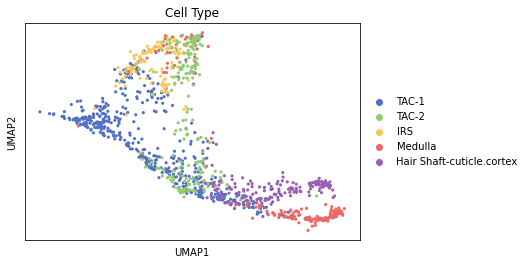

In [12]:
sc.pl.embedding(residual, basis='umap', color='celltype', title="Cell Type", palette=['#5470c6','#91cc75','#fac858','#ee6666','#9a60b4'], size=40)

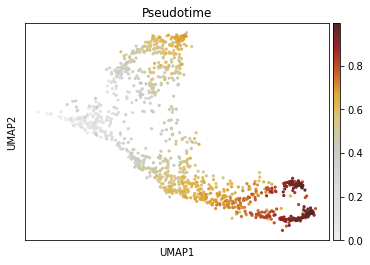

In [13]:
sc.pl.embedding(residual, basis='umap', color='time', title="Pseudotime", color_map = wcmp, size=40)

In [14]:
## load Prediction and Measurement
predict_rna = ad.AnnData(scale_data(predict_RNA_count_onlyatac), obs=dict(obs_names=adata_hvg_keep.obs_names.tolist()), var=dict(var_names=adata_hvg_keep.var_names), dtype='float')
truth_rna = ad.AnnData(scale_data(adata_hvg_keep.X.A), obs=dict(obs_names=adata_hvg_keep.obs_names.tolist()), var=dict(var_names=adata_hvg_keep.var_names), dtype='float')
predict_rna.obsm['X_umap'] = umap.loc[residual.obs_names.tolist(),].to_numpy()
predict_rna.obs['celltype'] = ct.loc[residual.obs_names.tolist(),'celltype'].values
truth_rna.obsm['X_umap'] = umap.loc[residual.obs_names.tolist(),].to_numpy()
truth_rna.obs['celltype'] = ct.loc[residual.obs_names.tolist(),'celltype'].values

##### loess of residual

In [ ]:
import os
os.system('Rscript loess.R')

##### Residual of Gli3

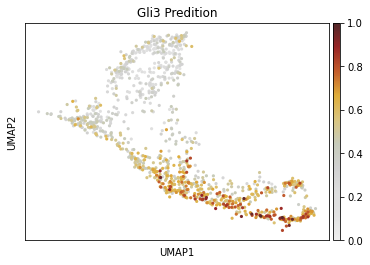

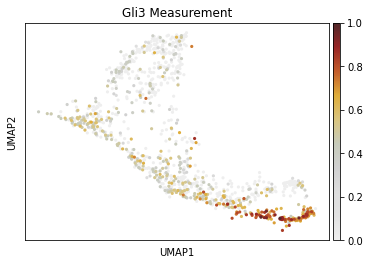

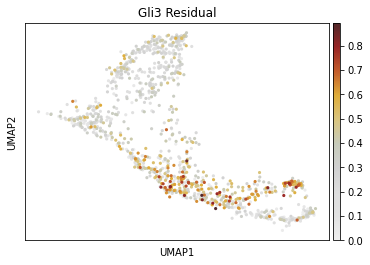

In [15]:
sc.pl.embedding(predict_rna, basis='umap', color=['Gli3'], color_map = wcmp, size=40, title='Gli3 Predition')
sc.pl.embedding(truth_rna, basis='umap', color=['Gli3'], color_map = wcmp, size=40, title='Gli3 Measurement')
sc.pl.embedding(residual, basis='umap', color=['Gli3'], color_map = wcmp, size=40, title='Gli3 Residual')

##### Visualize 12 peaks of Gli3

In [16]:
## load preprocessed ATAC normalized count
## input: atac_data.mtx, atac_cell.txt and atac_gene.txt. They are generated from share.rds in regulation_shift.ipynb
dd = sc.read('atac_data.mtx')
dd.obs_names = pd.read_csv('atac_cell.txt',header=None)[0].values
dd.var_names = pd.read_csv('atac_peak.txt',header=None)[0].values
common_genes = set(dd.obs_names) & set(ct.index)
dd = dd[list(common_genes)]
dd.obsm['X_umap'] = umap.loc[dd.obs_names,].to_numpy()
dd.obs['celltype'] = ct.loc[dd.obs_names,'celltype'].values

In [17]:
aw = pd.read_csv('Gli3.tsv', sep="\t")

In [18]:
gli3 = dd[:,aw.peak]
gli3_s = ad.AnnData(gli3.X.A, obs=dict(obs_names=gli3.obs_names.tolist()), var=dict(var_names=gli3.var_names), dtype='float')

In [19]:
gli3_s.obsm['X_umap'] = gli3.obsm['X_umap'].copy()
gli3_s.obs['celltype'] = gli3.obs['celltype']

In [20]:
deact = ['chr13-15741721-15742021','chr13-15580633-15580933','chr13-15022573-15022873','chr13-15481138-15481438','chr13-15466169-15466469','chr13-15514108-15514408']
act = ['chr13-15194824-15195124','chr13-15209813-15210113','chr13-15179030-15179330','chr13-15419554-15419854','chr13-15510896-15511196','chr13-15395260-15395560']

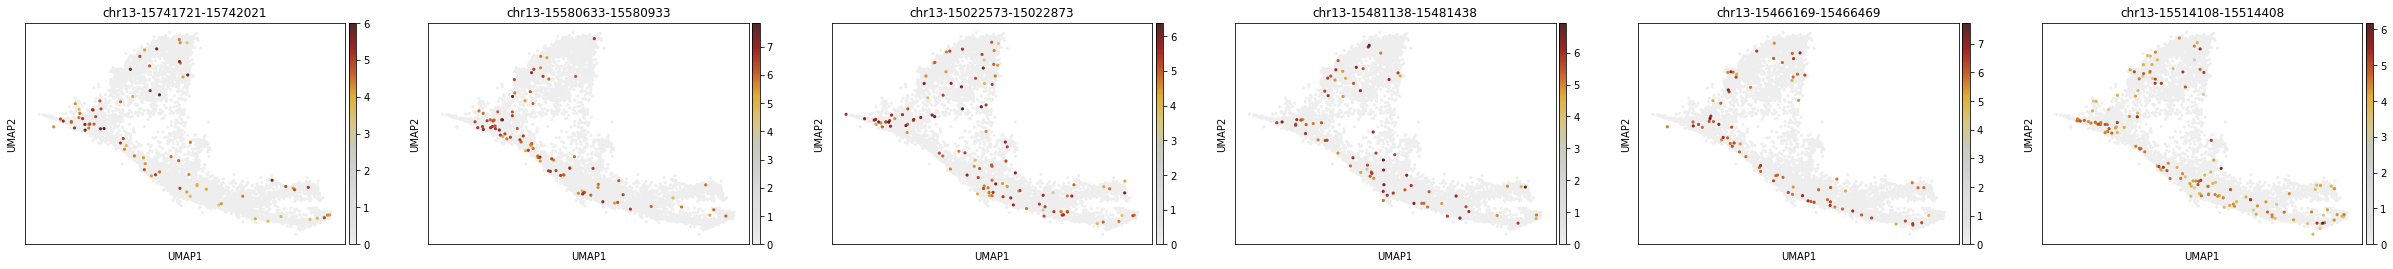

In [21]:
sc.pl.embedding(gli3_s, basis='umap', color=deact, color_map = wcmp, size=40, ncols=6)

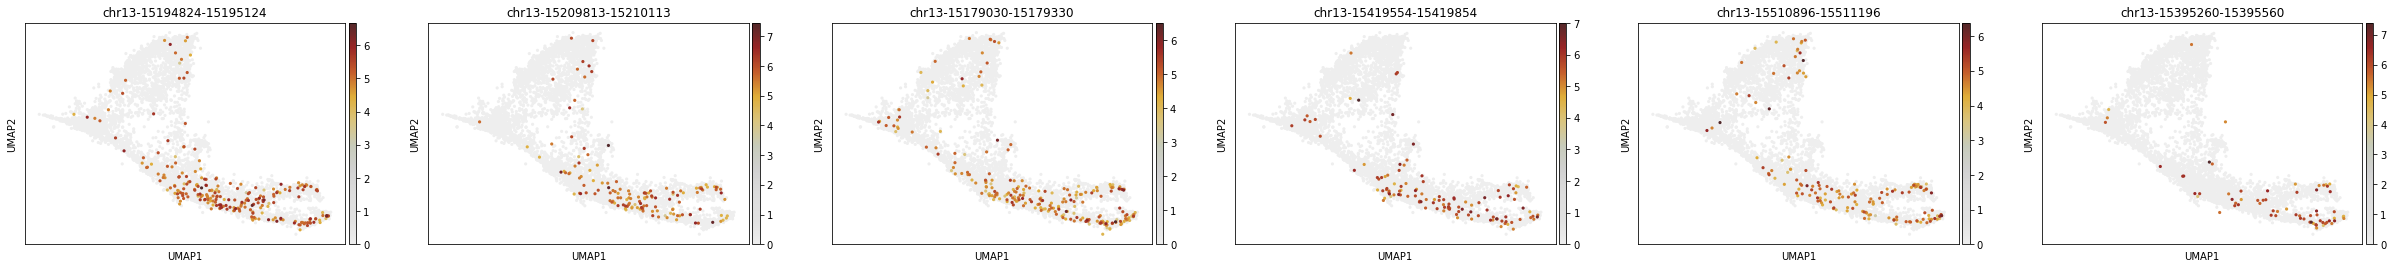

In [22]:
sc.pl.embedding(gli3_s, basis='umap', color=act, color_map = wcmp, size=40, ncols=6)